In [1]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

configure_plot_style()

In [2]:
def load_data(fpath):
    data = pd.read_csv(fpath)
    data['geometry'] = gpd.points_from_xy(data.long, data.lat)
    data = gpd.GeoDataFrame(data, crs='EPSG:4326')
    
    return data

folder = 'data'
modified_data = False
fpath_1 = here(os.path.join(folder, 'disaster_locations_gpt_repaired_w_features.csv'))
fpath_2 = here(os.path.join(folder, 'disaster_locations_gpt_repaired.csv'))
if os.path.exists(fpath_1):
    data = load_data(fpath_1)
elif os.path.exists(fpath_2):
    data = load_data(fpath_2)
else:
    raise ValueError('Go run the GPT notebook first!')

In [3]:
emdat = load_emdat_data()

In [4]:
data = (data
            .set_index(['emdat_index'])
            .join(emdat['df_raw_filtered_adj'])
            .reset_index(drop=False)
            .rename(columns={'index':'emdat_index'})
            .set_index(['emdat_index', 'location_id'])
       )

In [5]:
data.head()

name      lat      long  \
emdat_index location_id                                                   
1908.0      0.0                                Benin   9.3076    2.3158   
1911.0      0.0                               Gambia  13.4432  -15.3101   
2018.0      0.0                   Asunción, Paraguay -25.2637  -57.5759   
            1.0                 Concepción, Paraguay -23.3847  -57.3801   
2019.0      0.0          Santa Cruz, Solomon Islands -10.6140  165.1761   

                         distance_to_river  ORD_FLOW  HYRIV_ID  \
emdat_index location_id                                          
1908.0      0.0                  89.271135         4  10695619   
1911.0      0.0                   1.126871         4  10507767   
2018.0      0.0                   3.558485         3  61380542   
            1.0                  10.299119         3  61352866   
2019.0      0.0                1607.259409         4  50337362   

                         distance_to_coastline  is_island  \
emdat_index location_id                                     
1908.0      0.0                     327.990440      False   
1911.0      0.0                      30.453084      False   
2018.0      0.0                     915.979862      False   
            1.0                     991.587343      False   
2019.0      0.0                      60.870846       True   

                                          geometry         DisNo.  ...  \
emdat_index location_id                                            ...   
1908.0      0.0              POINT (2.3158 9.3076)  1969-9006-BEN  ...   
1911.0      0.0           POINT (-15.3101 13.4432)  1969-9006-GMB  ...   
2018.0      0.0          POINT (-57.5759 -25.2637)  1971-0007-PRY  ...   
            1.0          POINT (-57.3801 -23.3847)  1971-0007-PRY  ...   
2019.0      0.0           POINT (165.1761 -10.614)  1971-0008-SLB  ...   

                        Reconstruction_Costs_Adjusted Insured_Damage  \
emdat_index location_id                                                
1908.0      0.0                                   NaN            NaN   
1911.0      0.0                                   NaN            NaN   
2018.0      0.0                                   NaN            NaN   
            1.0                                   NaN            NaN   
2019.0      0.0                                   NaN            NaN   

                        Insured_Damage_Adjusted Total_Damage  \
emdat_index location_id                                        
1908.0      0.0                             NaN          NaN   
1911.0      0.0                             NaN        200.0   
2018.0      0.0                             NaN         50.0   
            1.0                             NaN         50.0   
2019.0      0.0                             NaN          NaN   

                        Total_Damage_Adjusted        CPI Admin Units  \
emdat_index location_id                                                
1908.0      0.0                           NaN  13.723806         NaN   
1911.0      0.0                        1505.0  13.288956         NaN   
2018.0      0.0                         376.0  13.288956         NaN   
            1.0                         376.0  13.288956         NaN   
2019.0      0.0                           NaN  13.288956         NaN   

                         Entry Date Last Update       disaster_class  
emdat_index location_id                                               
1908.0      0.0          2006-11-24  2023-09-25       Climatological  
1911.0      0.0          2006-08-08  2023-09-25       Climatological  
2018.0      0.0          2003-07-01  2023-09-25  Hydrometereological  
            1.0          2003-07-01  2023-09-25  Hydrometereological  
2019.0      0.0          2003-07-01  2023-09-25                 None  

[5 rows x 56 columns]

In [6]:
world = load_shapefile('world')
laos = load_shapefile('laos')
coastline = load_shapefile('coastline')
rivers = load_rivers_data()

/tmp/ipykernel_43150/3914288617.py:4: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  rivers = load_rivers_data()


<Axes: >

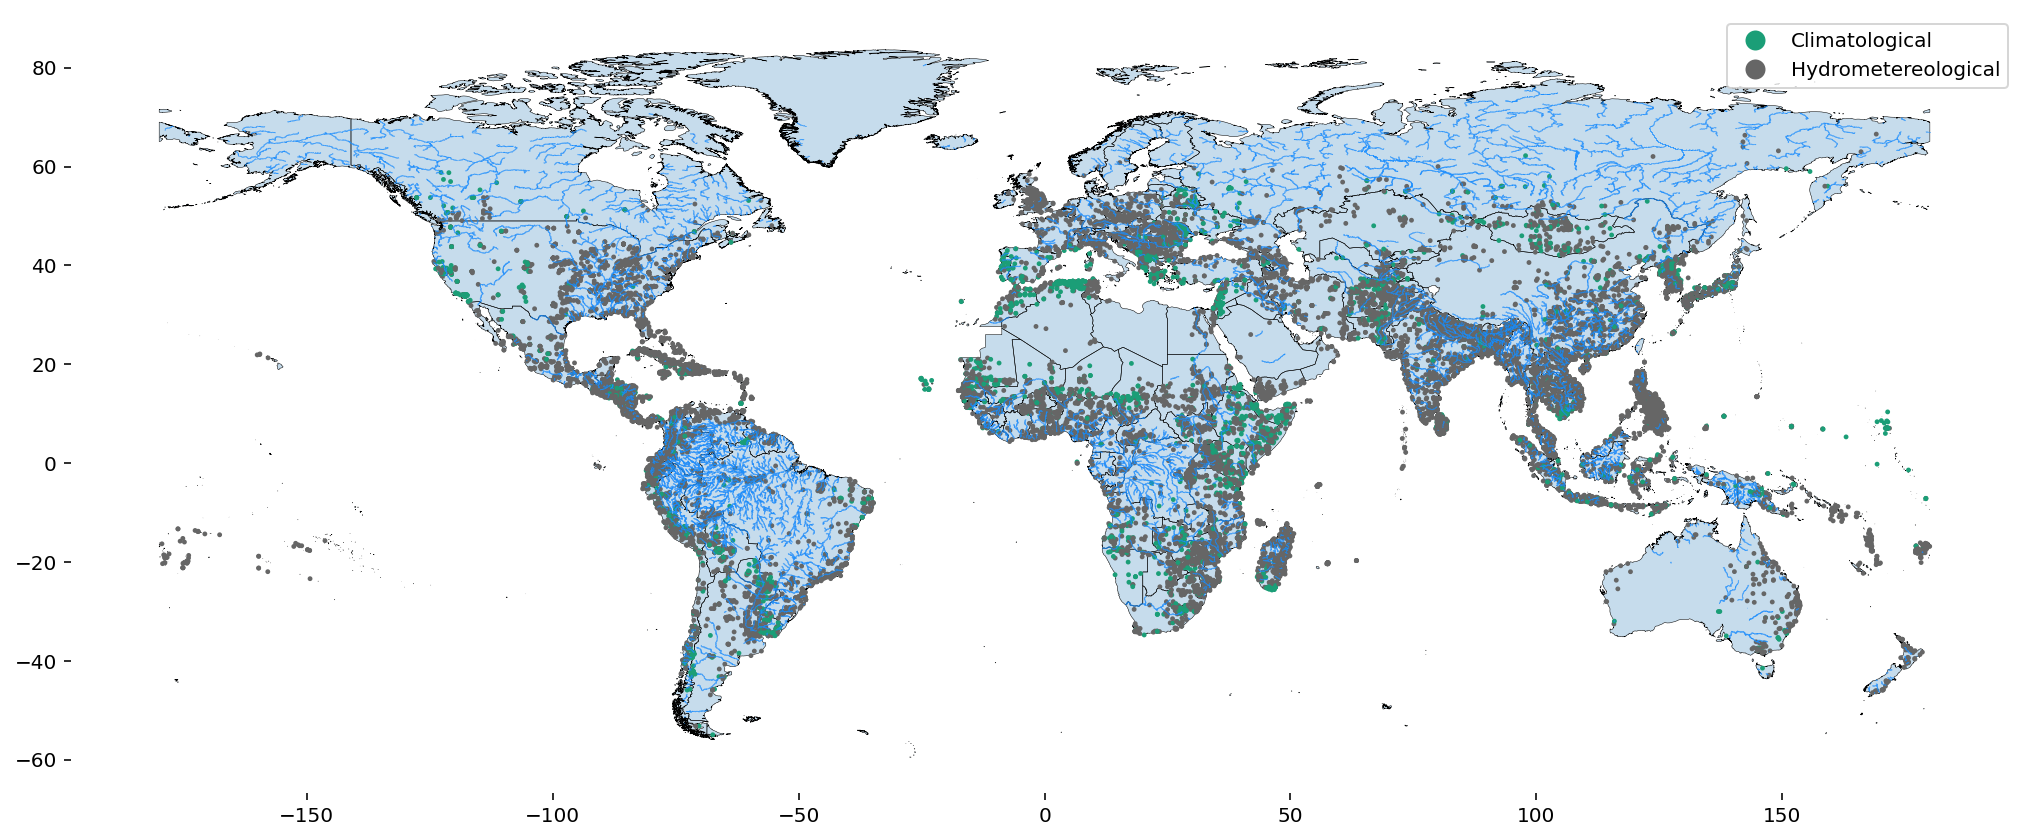

In [7]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('disaster_class', markersize=2, ax=ax, legend=True, cmap='Dark2')

In [8]:
from joblib import Parallel, delayed
import pandas as pd
from tqdm.notebook import tqdm

def get_distance_to(gdf, points, return_columns=None, crs="EPSG:3395", n_cores=-1):
    if return_columns is None:
        return_columns = []
        
    gdf_km = gdf.copy().to_crs(crs)
    points_km = points.copy().to_crs(crs)
    
    def get_closest(idx, row, gdf_km, return_columns):
        series = gdf_km.distance(row.geometry)
        index = series[series == series.min()].index[0]

        ret_vals = (series.min(), )
        for col in return_columns:
            ret_vals += (gdf_km.loc[index][col], )
        
        return ret_vals
    
    with Parallel(n_cores, require='sharedmem') as pool:
        results = pool(delayed(get_closest)(idx, row, gdf_km, return_columns) for idx, row in tqdm(points_km.iterrows(), total=points.shape[0]))
    return pd.DataFrame(results, columns = ['distance_to_closest'] + return_columns, index=points.index)

In [9]:
if 'distance_to_river' not in data.columns:
    distances = get_distance_to(rivers, points=data, return_columns=['ORD_FLOW', 'HYRIV_ID']).rename(columns={'distance_to_closest':'distance_to_river'})
    data = data.join(distances).assign(distance_to_river = lambda x: x.distance_to_river / 1000)
    modified_data = True

<Axes: ylabel='Frequency'>

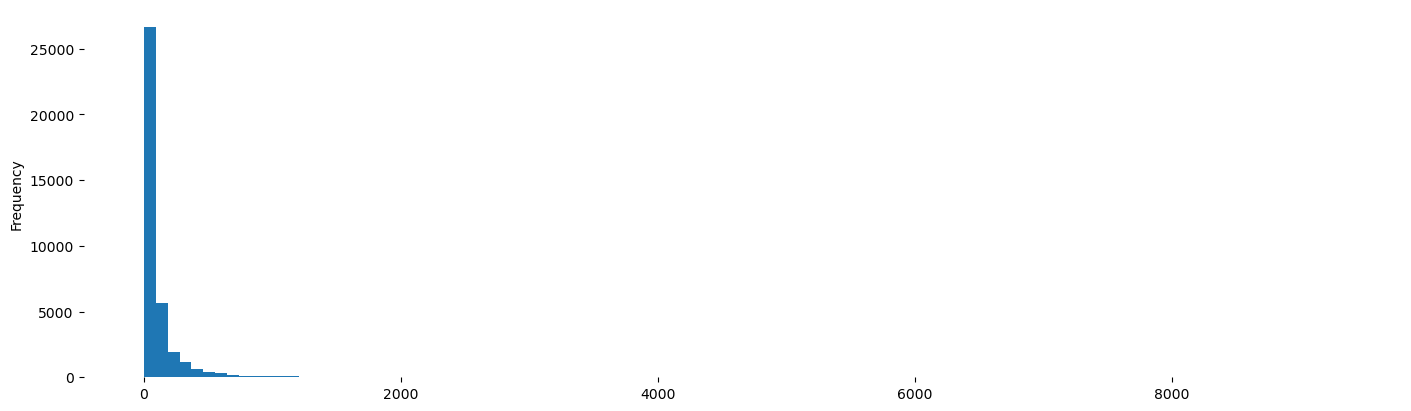

In [10]:
data.distance_to_river.plot.hist(bins=100)

In [11]:
if 'distance_to_coastline' not in data.columns:
    distances = get_distance_to(coastline.boundary, points=data.loc[:, ['geometry']]).rename(columns={'distance_to_closest':'distance_to_coastline'})
    data = data.join(distances).assign(distance_to_coastline = lambda x: x.distance_to_coastline / 1000)
    modified_data = True

<Axes: ylabel='Frequency'>

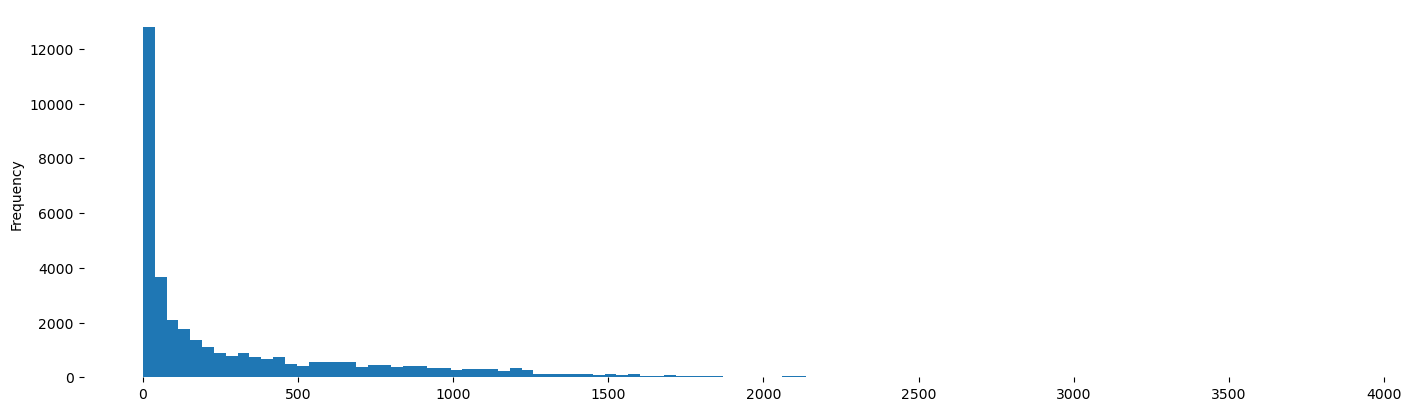

In [12]:
data.distance_to_coastline.plot.hist(bins=100)

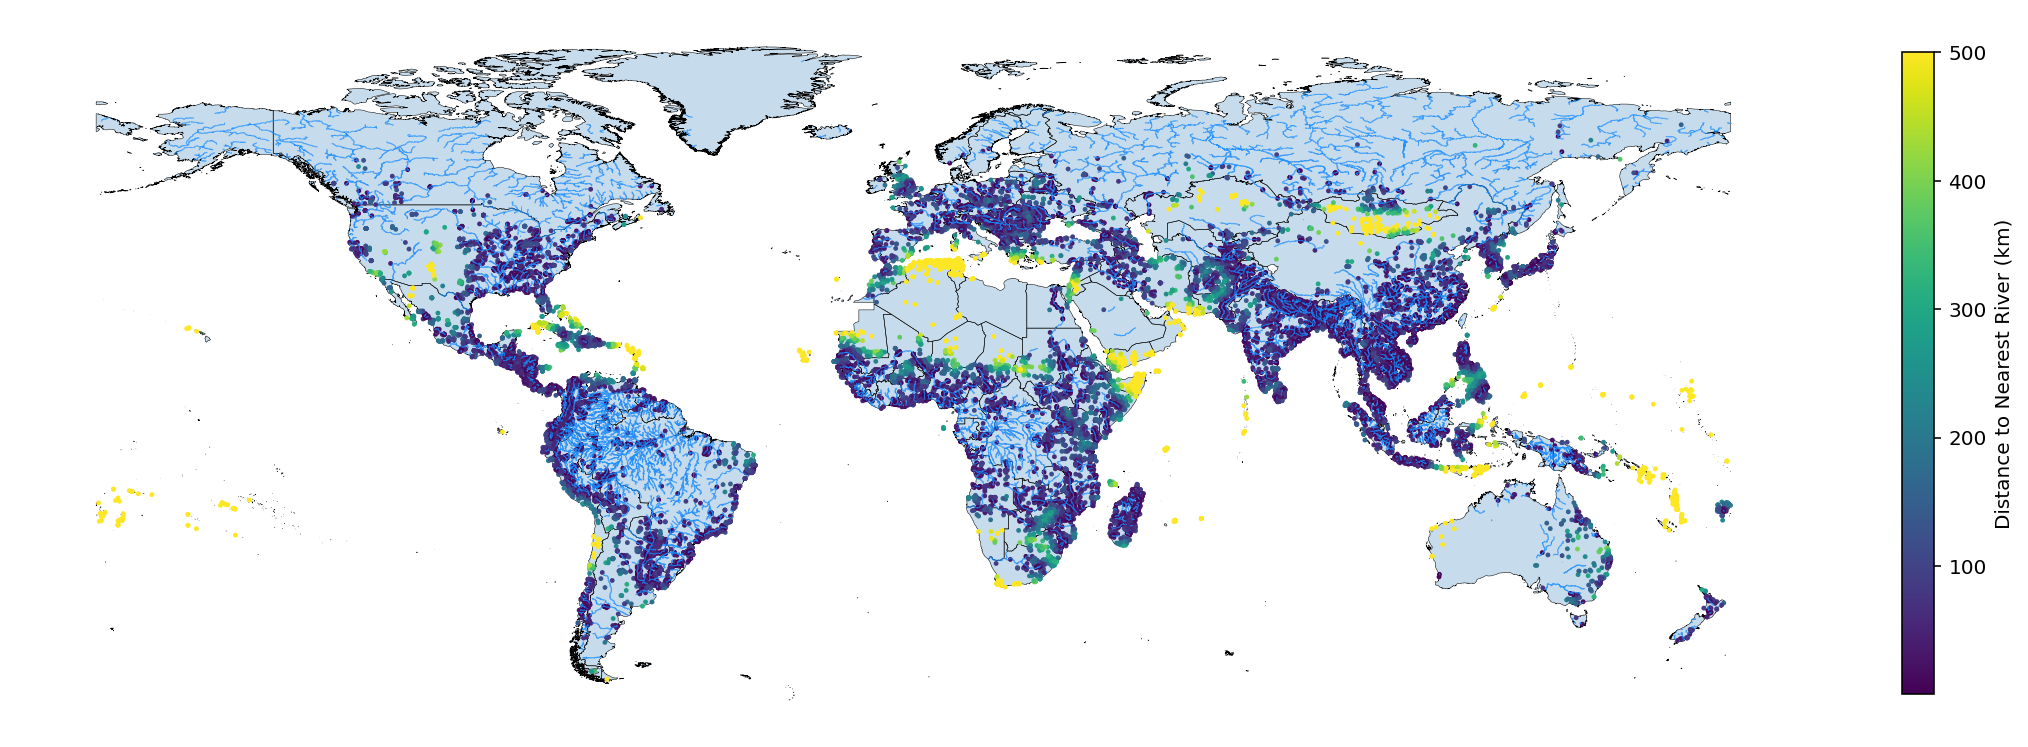

In [13]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_river', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500, 
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest River (km)'})
ax.axis('off')
plt.show()

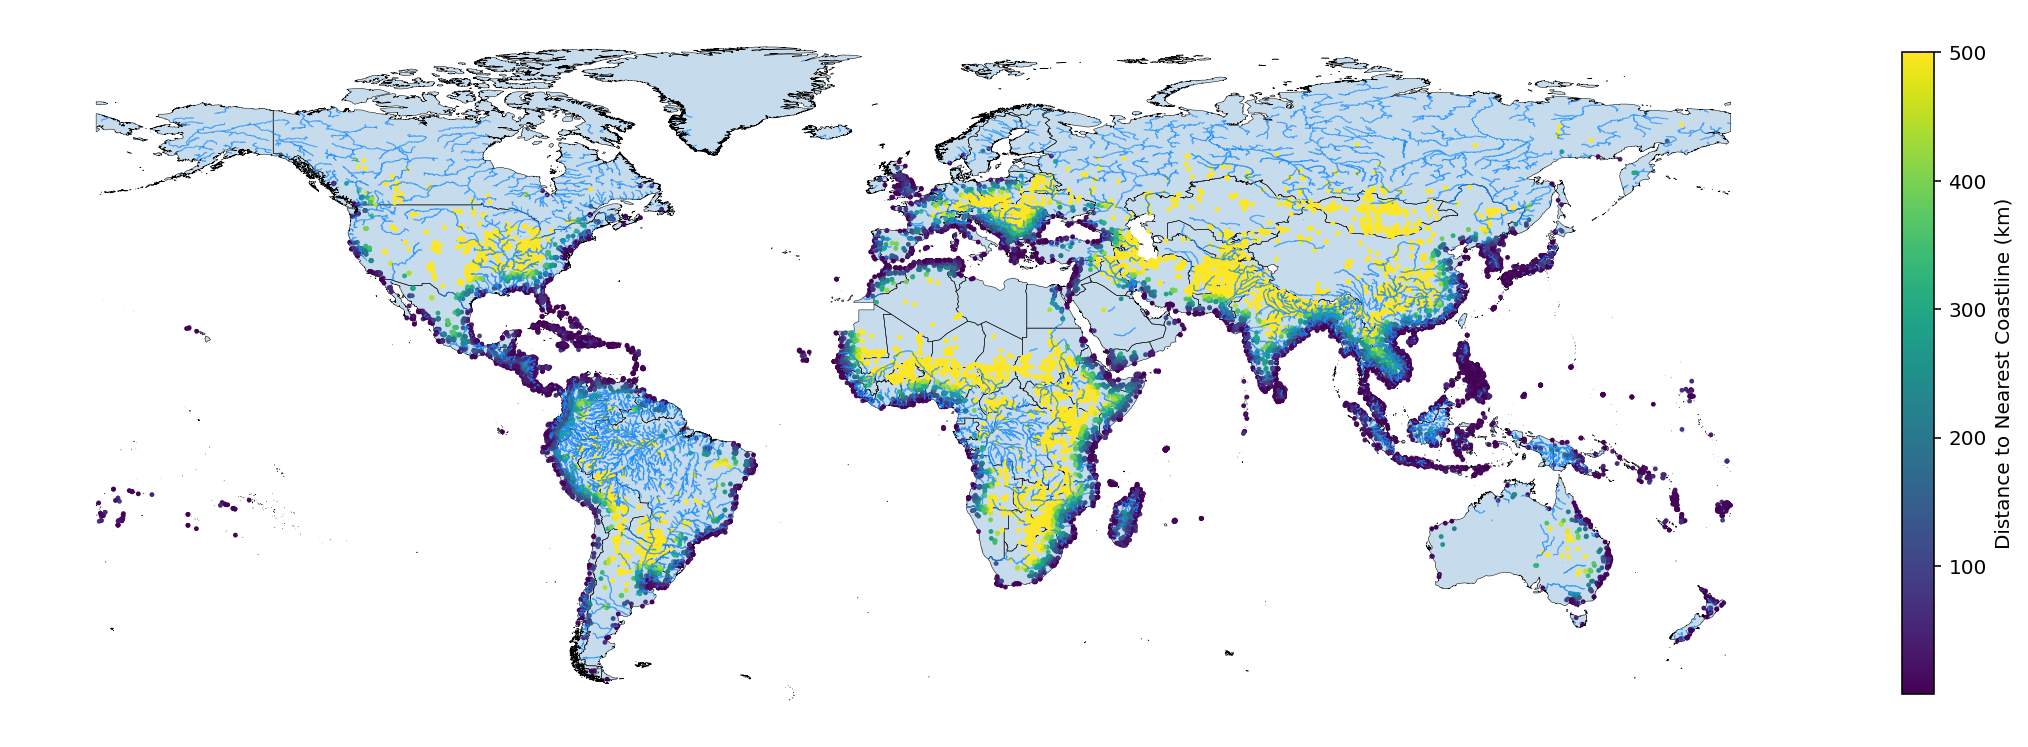

In [14]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_coastline', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500,
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest Coastline (km)'})
ax.axis('off')
plt.show()

In [15]:
if 'is_island' not in data.columns:
    try:
        import wikipedia as wp
    except ImportError:
        !mamba install wikipedia -q -y
        import wikipedia as wp

    html = wp.page("List_of_island_countries").html().encode("UTF-8")
    island_table = (pd.read_html(html, skiprows=0)[0]
                        .droplevel(axis=1, level=0)
                        .dropna(how='all').iloc[1:]
                        .reset_index(drop=True)
                        .assign(ISO_2 = lambda x: x['ISO code'].str.split().str[0],
                                ISO_3 = lambda x: x['ISO code'].str.split().str[1].replace({'or':'GBR'}))
                   )
    data['is_island'] = data.ISO.isin(island_table.ISO_3)
    modified_data = True

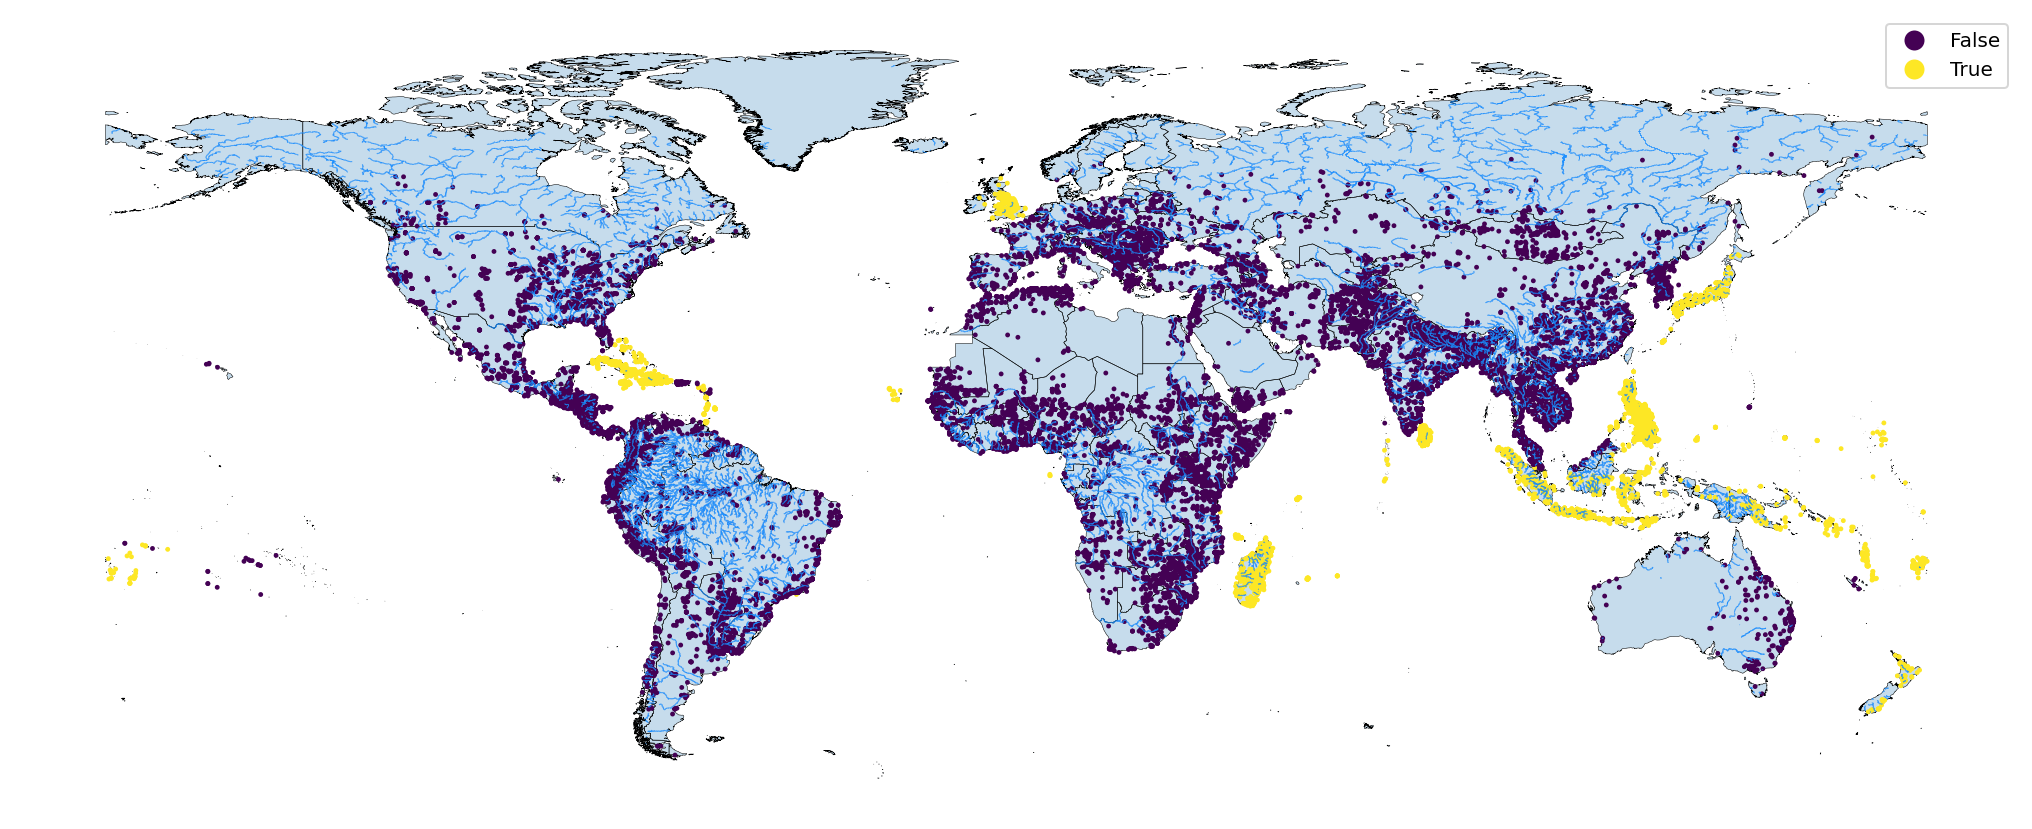

In [16]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

data.dropna(subset='disaster_class').plot('is_island', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.show()

In [17]:
if modified_data:
    (data
         .drop(columns=emdat['df_raw_filtered_adj'].columns.tolist() + ['geometry'])
         .to_csv(fpath_1))

# Synthetic Data

Create a bunch of dummy datapoints with geospatial features. These will be non-disasters. The model will need to distinguish the real disaster data from these fake points.

In [18]:
if not os.path.exists(here('data/synthetic_non_disasters.csv')):
    seed = sum(map(ord, 'Laos GGGI Climate Adaptation'))
    rng = np.random.default_rng(seed)

    # "Melt" the world into 5 regions - Americas, Europe, Asia, Afria, Oceania. This corresponds with the "Regions" column from EMDAT
    simple_world = (world
                        .replace({'North America':'Americas', 'South America':'Americas'})
                        .query('CONTINENT != "Seven seas (open ocean)"')
                        .dissolve('CONTINENT')
                        .loc[data.Region.unique()])

    # For every region, sample a random point for each disaster observed in that region
    not_disasters = (simple_world
                         .sample_points(data.groupby('Region').size().values, rng=rng)
                         .explode()
                         .reset_index()
                         .rename(columns={'CONTINENT':'Region', 'sampled_points':'geometry'})
                         .set_geometry('geometry'))

    # Compute geospatial features for the artifical data
    iso_dicts = [gpd.sjoin(world.loc[[i]], not_disasters, predicate='contains')[['ISO_A3', 'index_right']].set_index('index_right').to_dict()['ISO_A3'] for i in world.index]
    island_dict = data[['ISO', 'is_island']].drop_duplicates().set_index('ISO').to_dict()['is_island']
    not_disasters = not_disasters.join(pd.Series({k:v for d in iso_dicts for k, v in d.items()}, name='ISO'))
    not_disasters['is_island'] = not_disasters['ISO'].map(island_dict.get)

    distances = get_distance_to(rivers, points=not_disasters, return_columns=['ORD_FLOW', 'HYRIV_ID']).rename(columns={'distance_to_closest':'distance_to_river'})
    not_disasters = not_disasters.join(distances).assign(distance_to_river = lambda x: x.distance_to_river / 1000)

    distances = get_distance_to(coastline.boundary, points=not_disasters, return_columns=None).rename(columns={'distance_to_closest':'distance_to_coastline'})
    not_disasters = not_disasters.join(distances).assign(distance_to_coastline = lambda x: x.distance_to_coastline / 1000)
    
    not_disasters['long'] = not_disasters.geometry.apply(lambda x: x.x)
    not_disasters['lat'] = not_disasters.geometry.apply(lambda x: x.y)
    
    # Match each synthetic datapoint with a real datapoint and save the "twin" index 
    # Use this to merge more features (start date, disaster class) onto the fake data
    not_disasters.sort_values(by=['Region', 'ISO'], inplace=True)
    not_disasters['twin_emdat_index'] = data.index.get_level_values(0)
    not_disasters['twin_location_id'] = data.index.get_level_values(1)
    not_disasters.sort_index().drop(columns=['geometry']).to_csv(here('data/synthetic_non_disasters.csv'))

else:
    not_disasters = pd.read_csv(here('data/synthetic_non_disasters.csv'))
    not_disasters['geometry'] = gpd.points_from_xy(not_disasters.long, not_disasters.lat)
    not_disasters = gpd.GeoDataFrame(not_disasters, crs=data.crs)

# TODO:

- Merge together the fake and real data
- Make a "target" column with is_disaster = 1 if real, else 0
- Merge WB and climate features
- Do Logistic regression